### Paso 1: Importación de librerías

In [8]:
# Librerias utilizadas
# pip install yfinance
# o si es en Conda, conda install -c ranaroussi yfinance
import yfinance as yf
import pandas as pd
import os

from datetime import datetime
import pytz

### Paso 2: Stocks seleccionados

In [10]:
# Descargamos los datos de Yahoo Finance
# Si no existe el archivo, lo descargamos
# Si existe, lo leemos

# SP500
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

# TSLA
if os.path.exists("tsla.csv"):
    tsla = pd.read_csv("tsla.csv", index_col=0)
else:
    tsla = yf.Ticker("TSLA")
    tsla = tsla.history(period="max")
    tsla.to_csv("tsla.csv")

### Paso 3: Limpieza de Datos

In [6]:
# Convertimos el indice a formato fecha usando pandas
# print(sp500.index)
sp500.index = pd.to_datetime(sp500.index)

del sp500["Dividends"]
del sp500["Stock Splits"]
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

min_date = datetime(year=1990, month=1, day=1)
min_date = pytz.utc.localize(min_date)
sp500 = sp500[sp500.index > min_date]

<Axes: xlabel='Date'>

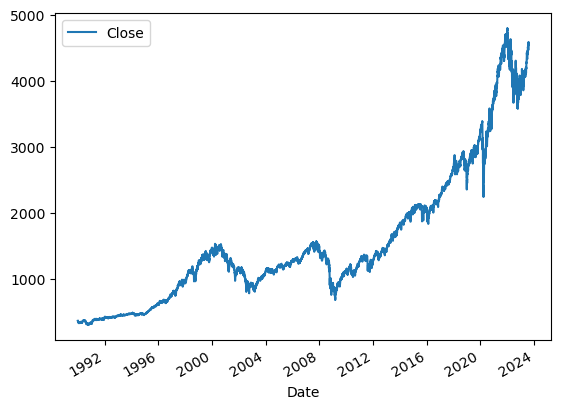

In [7]:
sp500.plot.line(y="Close", use_index=True)

In [39]:
# Dividimos el dataset en train y test
# Hacemos el modelo del 
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"] # Variables que vamos a usar para predecir
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

Si una inteligencia artificial fuera una funcion de varios inputs,
f(x1, x2, x3, ..., xn) = y,
x1 al xn serían las variables de entrada, `predictors = ["Close", "Volume", "Open", "High", "Low"]`

y sería la variable de salida sería Target, que representa si el precio de la acción subió o bajó.

In [40]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5357142857142857

In [42]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [43]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [44]:
predictions = backtest(sp500, model, predictors)

In [45]:
predictions["Predictions"].value_counts()

0    3433
1    2530
Name: Predictions, dtype: int64

In [46]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5296442687747036

In [47]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.533959
0    0.466041
Name: Target, dtype: float64

In [48]:
horizons = [2,4,8,16,32,64,128]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

C:\Users\Raul\AppData\Local\Temp\ipykernel_8320\3433483589.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
C:\Users\Raul\AppData\Local\Temp\ipykernel_8320\3433483589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
C:\Users\Raul\AppData\Local\Temp\ipykernel_8320\3433483589.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [49]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [50]:
#sp500

In [51]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [52]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [53]:
predictions = backtest(sp500, model, new_predictors)

In [54]:
predictions["Predictions"].value_counts()

0.0    1675
1.0     192
Name: Predictions, dtype: int64

In [55]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4947916666666667

<Axes: xlabel='Date'>

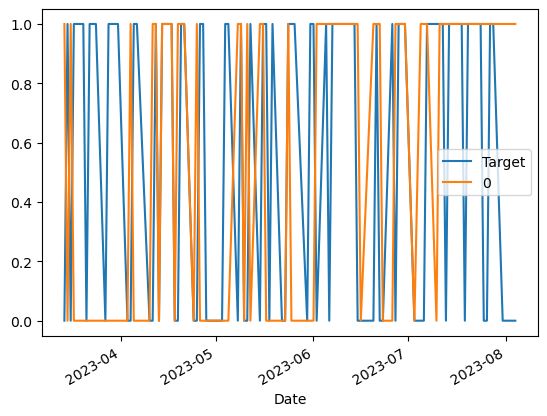

In [58]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()